In [1]:
! pip install --no-deps git+https://github.com/salute-developers/GigaAM.git pywer hydra-core kenlm flashlight-text

  Cloning https://github.com/salute-developers/GigaAM.git to /tmp/pip-req-build-0u7kke4g
  Running command git clone --filter=blob:none --quiet https://github.com/salute-developers/GigaAM.git /tmp/pip-req-build-0u7kke4g
  Resolved https://github.com/salute-developers/GigaAM.git to commit 6a8b511f753670ed38af6529bb89bbdc2191ba6a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 8.1 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:0000:01
  Created wheel for gigaam: filename=gigaam-0.1.0-py3-none-any.whl size=22491 sha256=52eeee9f804bdde2190f47efbd9dcc45d7e19bf3399e886a45675facaf5a1d0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dqi870fi/wheels/40/c7/e4/49fa57736263c77f6f33

In [2]:
import os
import matplotlib.pyplot as plt
import torch
from typing import List
import pywer
from tqdm import tqdm
import omegaconf
import gigaam
import IPython
import random
import numpy as np

In [3]:
! pip install datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.9.0
    Uninstalling fsspec-2025.9.0:
      Successfully uninstalled fsspec-2025.9.0
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:
      Successfully uninstalled dill-0.4.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.1.1
    Uninstalling datasets-4.1.1:
      Successfully uninstalled datasets-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 req

In [4]:
from datasets import load_dataset
from torch.utils.data import DataLoader

In [ ]:
! pip list | grep datasets

In [5]:
# fleurs = load_dataset("google/fleurs", "ru_ru", split="train")
fleurs = load_dataset("google/fleurs", "ru_ru")

README.md: 0.00B [00:00, ?B/s]

fleurs.py: 0.00B [00:00, ?B/s]

The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


data/ru_ru/audio/train.tar.gz:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

data/ru_ru/audio/dev.tar.gz:   0%|          | 0.00/187M [00:00<?, ?B/s]

data/ru_ru/audio/test.tar.gz:   0%|          | 0.00/433M [00:00<?, ?B/s]

train.tsv: 0.00B [00:00, ?B/s]

dev.tsv: 0.00B [00:00, ?B/s]

test.tsv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
from torch.utils.data import Dataset

In [8]:
class AudioDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        return {
            'id': sample['id'],
            'num_samples': torch.tensor(sample['num_samples'], dtype=torch.int32),
            'path': sample['path'],
            'audio': torch.tensor(sample['audio']['array'], dtype=torch.float32),
            'transcription': sample['transcription'],
            'raw_transcription': sample['raw_transcription'],
            'gender': sample['gender'],
            'lang_id': torch.tensor(sample['lang_id'], dtype=torch.int32),
            'language': sample['language'],
            'lang_group_id': torch.tensor(sample['lang_group_id'], dtype=torch.int32)
        }

In [9]:
def collate_fn(batch):
    # Для полей с разной длиной (например, audio) нужно добавить паддинг
    audio = [item['audio'] for item in batch]
    audio_padded = torch.nn.utils.rnn.pad_sequence(audio, batch_first=True)

    # return {
    #     'id': [item['id'] for item in batch],
    #     'num_samples': torch.stack([item['num_samples'] for item in batch]),
    #     'path': [item['path'] for item in batch],
    #     'audio': audio_padded,
    #     'transcription': [item['transcription'] for item in batch],
    #     'raw_transcription': [item['raw_transcription'] for item in batch],
    #     'gender': [item['gender'] for item in batch],
    #     'lang_id': torch.stack([item['lang_id'] for item in batch]),
    #     'language': [item['language'] for item in batch],
    #     'lang_group_id': torch.stack([item['lang_group_id'] for item in batch])
    # }
    return audio_padded, torch.stack([item['num_samples'] for item in batch]), [item['transcription'] for item in batch]

In [10]:
# #DEBUG
# def my_collate_fn(data):
#     # TODO: Implement your function
#     # But I guess in your case it should be:
#     # return tuple(data)
#     wav_batch = []
#     wav_lengths = []
#     texts = []

#     for item in data:
#       wav_batch.append(torch.tensor(item['audio']['array'], dtype=torch.float))
#       texts.append(item['transcription'])

#     wav_lengths = torch.tensor(wav_lengths, dtype=torch.float)

#     wav_batch = torch.nn.utils.rnn.pad_sequence(wav_batch, batch_first=True, padding_value=0)

#     # return torch.stack(wav_batch, dim=0), wav_lengths, texts
#     return wav_batch, wav_lengths, texts

# fleurs_train = fleurs['train'].remove_columns(['id', 'path', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'])
fleurs_train = fleurs['train']
# dataloader = DataLoader(fleurs_train, batch_size=32, collate_fn=my_collate_fn)

In [11]:
custom_dataset = AudioDataset(fleurs_train)
dataloader = DataLoader(
    custom_dataset,
    batch_size=1,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=1
)

# Model

In [12]:
from gigaam import GigaAMASR

CACHE_DIR = os.path.expanduser("~/.cache/gigaam")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name, model_path = gigaam._download_model('ctc', CACHE_DIR)

ckpt = torch.load(model_path, map_location='cpu', weights_only=False)

ckpt["cfg"].encoder.flash_attn = False
model = GigaAMASR(ckpt['cfg'])

model.load_state_dict(ckpt["state_dict"], strict=False)
model = model.eval()

if device.type != "cpu":
  model.encoder = model.encoder.half()

model = model.to(device)

100%|███████████████████████████████████████| 444M/444M [00:14<00:00, 31.3MiB/s]


In [14]:
param = next(model.parameters())
print('Model device:', param.device)
print('Model dtype:', param.dtype)
print('Parameters count:', sum(p.numel() for p in model.parameters()))

DEVICE = param.device

Model device: cuda:0
Model dtype: torch.float16
Parameters count: 232585762


In [ ]:
#model

In [ ]:
wav_path_example = '/root/.cache/huggingface/datasets/downloads/extracted/a2d3fe0258fe892f72f60a3a351ce767d90291abb07f8068cb630764d03dc666/train/10002203722064200187.wav'
model.transcribe(wav_path_example)

In [ ]:
IPython.display.Audio(wav_path_example)

In [15]:
def fix_torch_seed(seed: int = 42):
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

    print(f"✅ Random seed fixed to {seed}")

# Example usage:
fix_torch_seed(1234)

✅ Random seed fixed to 1234


In [ ]:
# dataloader = DataLoader(fleurs, batch_size=32)

In [27]:
def get_gigaam_logprobs(model, wav_batch, wav_lengths, return_transcriptions=False):
    wav_batch = wav_batch.to(model._device)
    wav_lengths = wav_lengths.to(model._device)

    encoded, encoded_len = model.forward(wav_batch, wav_lengths)

    logprobs = model.head(encoded)

    if return_transcriptions:
        transcriptions = model.decoding.decode(model.head, encoded, encoded_len)
        return logprobs, encoded_len, transcriptions
    else:
        return logprobs, encoded_len

In [28]:
def calculate_wer_on_dataset(model, dataloader, batch_size=8, num_workers=2, return_transcriptions=False):
  # dataloader = torch.utils.data.DataLoader(
  #     dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers,
  # )
  references = []
  hypotheses = []

  for batch in tqdm(dataloader):
      wav_batch, wav_lengths, texts = batch
      logprobs, lengths, transcriptions = get_gigaam_logprobs(model, wav_batch, wav_lengths, return_transcriptions=True)
      references.extend(texts)
      hypotheses.extend(transcriptions)

  wer = pywer.wer(references, hypotheses)
  if return_transcriptions:
    return wer, references, hypotheses

  return wer

In [29]:
wer, references, hypotheses = calculate_wer_on_dataset(model, dataloader, return_transcriptions=True)
print('\nWER on farfield: ', wer)

100%|██████████| 2562/2562 [02:39<00:00, 16.06it/s]


WER on farfield:  10.896309314586995


# Beamsearch alg

In [18]:
! gdown https://drive.google.com/uc?id=1_y5lrX8IX7hBJpFW9YiDURb6zZDufMXJ
! gdown https://drive.google.com/uc?id=1FCDtZjQ3AS8ZdCn7H-Cy56yCJLhkReO8

Downloading...
From: https://drive.google.com/uc?id=1_y5lrX8IX7hBJpFW9YiDURb6zZDufMXJ
To: /kaggle/working/lexicon.txt
100%|███████████████████████████████████████| 1.70M/1.70M [00:00<00:00, 163MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1FCDtZjQ3AS8ZdCn7H-Cy56yCJLhkReO8
From (redirected): https://drive.google.com/uc?id=1FCDtZjQ3AS8ZdCn7H-Cy56yCJLhkReO8&confirm=t&uuid=7cd5709b-44b3-433d-94f8-2ecb4f7430cb
To: /kaggle/working/lm_50x50.binary
100%|██████████████████████████████████████| 2.55G/2.55G [00:27<00:00, 94.0MB/s]


In [19]:
import kenlm
from torchaudio.models.decoder import ctc_decoder
import editdistance

LM_PATH = '/kaggle/working/lm_50x50.binary'
LEXICON_PATH = '/kaggle/working/lexicon.txt'
lm_model = kenlm.LanguageModel(LM_PATH)

In [21]:
from torchaudio.models.decoder import ctc_decoder


TOKENS = ckpt['cfg'].decoding.vocabulary + ['|']

LM_WEIGHT = 2.0
WORD_SCORE = -0.5

beam_search_decoder = ctc_decoder(
    lexicon='/kaggle/working/lexicon.txt',
    tokens=TOKENS,
    nbest=10,
    beam_size=30,
    sil_token=' ',
    blank_token='|',
    lm='/kaggle/working/lm_50x50.binary',
    lm_weight=LM_WEIGHT,
    word_score=WORD_SCORE,
)

In [22]:
def decode_indices(labels, model):
    return "".join(model.decoding.tokenizer.decode(labels.cpu().tolist()))

class BeamSearchEvaluator:
    def __init__(self, model, beam_search_decoder, lm_model=None):
        self.model = model
        self.beam_search_decoder = beam_search_decoder
        self.lm_model = lm_model

    def set_beam_search_decoder(self, beam_search_decoder):
        self.beam_search_decoder = beam_search_decoder

    def set_lm_model(self, lm_model):
        self.lm_model = lm_model

    def evaluate(self, dataset, batch_size=8, num_workers=2):
        # dataloader = torch.utils.data.DataLoader(
        #     dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers
        # )
        dataloader = DataLoader(
            dataset,
            batch_size=1,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=1
        )

        refs, hyps, best_hyps = [], [], []
        rescored_hyps = [] if self.lm_model else None
        n_bests = []

        for wav_batch, wav_lengths, texts in tqdm(dataloader):
            logprob_batch, encoded_len_batch = get_gigaam_logprobs(self.model, wav_batch, wav_lengths)
            beamsearch_result = self.beam_search_decoder(logprob_batch.cpu(), encoded_len_batch.cpu())

            for i, result in enumerate(beamsearch_result):
                ref = texts[i]
                refs.append(ref)

                best_hyp, best_rescored_hyp = self._process_nbest(result, ref)
                hyps.append(best_hyp[0])
                best_hyps.append(best_hyp[1])
                n_bests.append(best_hyp[2])

                if self.lm_model:
                    rescored_hyps.append(best_rescored_hyp)

        return self._compute_metrics(refs, hyps, best_hyps, rescored_hyps, n_bests)

    def _process_nbest(self, result, ref):
        best_distance = float('inf')
        best_hyp = None
        first_hyp = None
        best_rescored_hyp = None
        best_score = -float('inf')
        nbest_list = []

        for j, candidate in enumerate(result):
            curr_tokens = candidate.tokens
            curr_hyp = decode_indices(curr_tokens, self.model)
            nbest_list.append({'hyp': curr_hyp, 'score': candidate.score})

            if j == 0:
                first_hyp = curr_hyp

            distance = editdistance.eval(ref.split(), curr_hyp.split())
            if distance < best_distance:
                best_distance = distance
                best_hyp = curr_hyp

            if self.lm_model:
                score = self.lm_model.score(curr_hyp) / len(curr_hyp)
                if score > best_score:
                    best_score = score
                    best_rescored_hyp = curr_hyp

        return (first_hyp, best_hyp, nbest_list), best_rescored_hyp

    def _compute_metrics(self, refs, hyps, best_hyps, rescored_hyps, n_bests):
        wer = pywer.wer(refs, hyps)
        oracle_wer = pywer.wer(refs, best_hyps)

        output = {
            'wer': wer,
            'oracle_wer': oracle_wer,
            'references': refs,
            'hypotheses': hyps,
            'oracle_hypotheses': best_hyps,
            'n_bests': n_bests
        }

        if self.lm_model:
            rescored_wer = pywer.wer(refs, rescored_hyps)
            output.update({
                'rescored_wer': rescored_wer,
                'rescored_hypotheses': rescored_hyps,
            })

        return output

In [23]:
evaluator = BeamSearchEvaluator(model, beam_search_decoder, lm_model=lm_model)
res = evaluator.evaluate(custom_dataset)
print('\nBeam search WER: ', res['wer'])
print('\nBeam search OracleWER: ', res['oracle_wer'])

  0%|          | 0/2562 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/transforms/_transforms.py:412: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  mel_specgram = torch.matmul(specgram.transpose(-1, -2), self.fb).transpose(-1, -2)
/usr/local/lib/python3.11/dist-packages/gigaam/encoder.py:196: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterm


Beam search WER:  41.41011061718184

Beam search OracleWER:  38.69740514835108


NameError: name 'wer_noisy' is not defined

# Тестирование качества работы декодера при варьировании параметра beam_size (количство рассматриваемых гипотиз)

In [25]:
BEAM_SIZES = [5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for beam_size in BEAM_SIZES:
    beam_search_decoder = ctc_decoder(
        lexicon=LEXICON_PATH,
        tokens=TOKENS,
        nbest=10,
        beam_size=beam_size,
        sil_token=' ',
        blank_token='|',
        lm=LM_PATH,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )
    evaluator.set_beam_search_decoder(beam_search_decoder)
    output = evaluator.evaluate(custom_dataset)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])

100%|██████████| 2562/2562 [05:01<00:00,  8.51it/s]


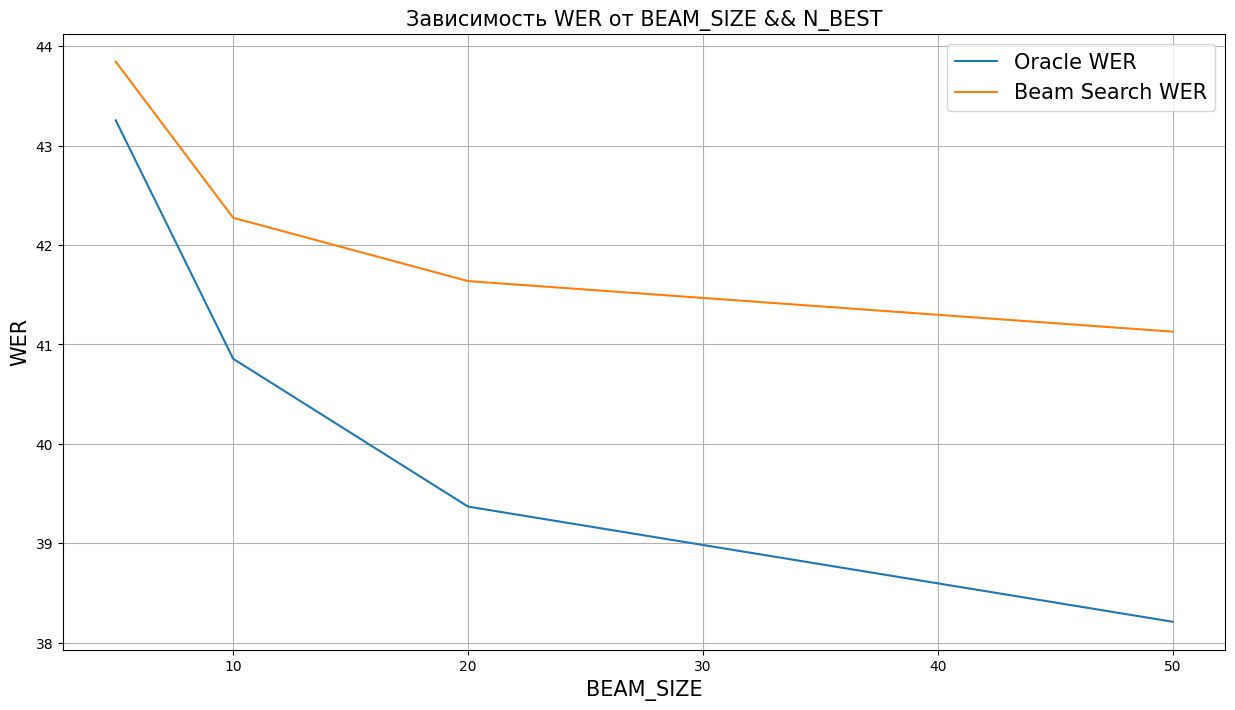

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(BEAM_SIZES, oracle_wer_results, label='Oracle WER')
plt.plot(BEAM_SIZES, wer_results, label='Beam Search WER')
plt.ylabel('WER', fontsize=15)
plt.xlabel('BEAM_SIZE', fontsize=15)
plt.title('Зависимость WER от BEAM_SIZE && N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

# Зависимость качества распознавания от параметра n_best

In [30]:
N_BESTS = [2, 5, 10, 20, 50]
wer_results = []
oracle_wer_results = []
rescored_wer_results = []

for n_best in N_BESTS:
    beam_search_decoder = ctc_decoder(
        lexicon=LEXICON_PATH,
        tokens=TOKENS,
        nbest=n_best,
        beam_size=50,
        sil_token=' ',
        blank_token='|',
        lm=LM_PATH,
        lm_weight=LM_WEIGHT,
        word_score=WORD_SCORE,
    )
    evaluator.set_beam_search_decoder(beam_search_decoder)
    output = evaluator.evaluate(custom_dataset)
    wer_results.append(output['wer'])
    oracle_wer_results.append(output['oracle_wer'])
    rescored_wer_results.append(output['rescored_wer'])

100%|██████████| 2562/2562 [05:25<00:00,  7.88it/s]


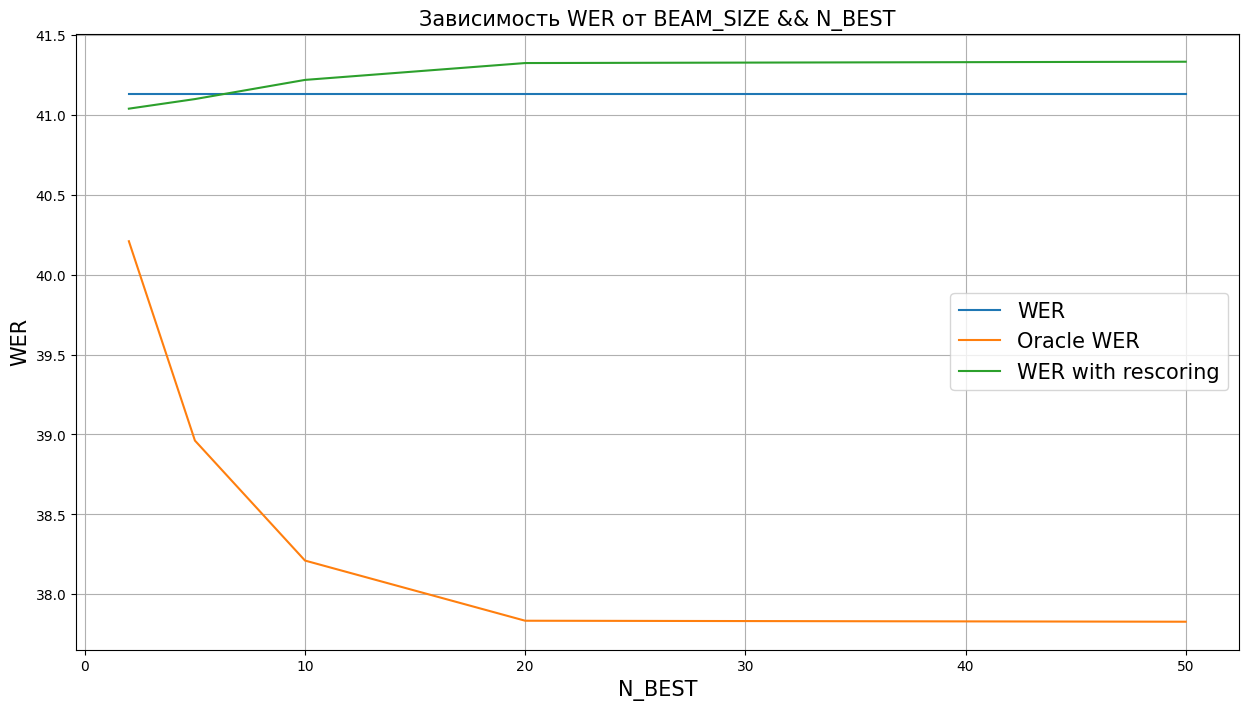

In [31]:
plt.figure(figsize=(15, 8))
plt.plot(N_BESTS, wer_results, label='WER')
plt.plot(N_BESTS, oracle_wer_results, label='Oracle WER')
plt.plot(N_BESTS, rescored_wer_results, label='WER with rescoring')

plt.ylabel('WER', fontsize=15)
plt.xlabel('N_BEST', fontsize=15)
plt.title('Зависимость WER от BEAM_SIZE && N_BEST', fontsize=15)
plt.legend(fontsize=15)
plt.grid()